# Deep Learning 2024 - Project Assignment




## Introduction

Deep neural networks suffer from severe performance degradation when being tested on images that are visually different from the ones encountered during training due to the *domain shift*, *noise* or *changes in lighting*.

Recent research has focused on devising domain adaptation techniques for building deep models that can adapt from an annotated source dataset to a target one. However, such methods require access to either downstream training data, which is difficult to collect.
Alternatively, there is **Test-Time adaptation** (TTA), which involves improving the robustness of a pre-trained neural network to a test dataset, possibly by improving the network's predictions on one test sample at time.
Two TTA methods for image classification are:
- [**Marginal Entropy Minimization with One test point** (MEMO)](https://arxiv.org/pdf/2110.09506) uses pretrained models directly without making any assumptions about their specific training procedures or architectures, requiring only a single test input for adaptation.
- [**Test-Time Prompt Tuning** (TPT)](https://arxiv.org/pdf/2209.07511) leverages pre-existing models without any assumptions about their specific training methods or architectures, enabling adaptation using only a small set of labeled examples from the target domain.

<u>For this project, it was decided to implement **MEMO**.</u>


## Marginal Entropy Minimization with One test point (MEMO)

For this project, MEMO was applied to a pretrained Convolutional Neural Network, **ViT-b/16**, using the **ImageNetV2** dataset. This network operates as follows: given a test point $x \in X$, it produces a conditional output distribution $p(y|x; w)$ over a set of classes $Y$, and predicts a label $\hat{y}$ as:

$$ \hat{y} = M(x | w) = \arg \max_{y \in Y} p(y | x; w) $$

<p align="center" text-align="center">
  <img width="75%" src="https://github.com/christiansassi/deep-learning-project/blob/main/assets/img1.jpg?raw=true">
  <br>
  <span><b>Fig. 1</b> MEMO overview</span>
</p>

Let $ A = \{a_1,...,a_M\} $ be a set of augmentations (resizing, cropping, color jittering etc...). Each augmentation $ a_i \in A $ can be applied to an input sample $x$, resulting in a transformed sample denoted as $a_i(x)$, as shown in figure. The objective here is to make the model's prediction invariant to those specific transformations.

MEMO starts by appling a set of $B$ augmentation functions sampled from $A$ to $x$. It then calculates the average, or marginal, output distribution $ \bar{p}(y | x; w) $ by averaging the conditional output distributions over these augmentations, represented as:

$$ \bar{p}(y | x; w) = \frac{1}{B} \sum_{i=1}^B p(y | a_i(x); w) $$

Since the true label $y$ is not available during testing, the objective of Test-Time Adaptation (TTA) is twofold: (i) to ensure that the model's predictions have the same label $y$ across various augmented versions of the test sample, (ii) to increase the confidence in the model's predictions, given that the augmented versions have the same label. To this end, the model is trained to minimize the entropy of the marginal output distribution across augmentations, defined as:

$$ L(w; x) = H(\bar{p}(\cdot | x;w)) = -\sum_{y \in Y} \bar{p}(y | x;w) \text{log} \bar{p}(y | x;w) $$

## Task

To outline the task and the experimental setup adopted it is essential to introduce two fundamental elements: the **dataset** and the **model**.

### Dataset: ImageNet-v2
[ImageNet-v2](https://imagenetv2.org/) is a dataset created as a validation benchmark for deep learning models trained on ImageNet, with the goal of testing their ability to generalize to new data. It includes three variants (which contain 10k images each) that allow evaluating the robustness and effectiveness of computer vision models and the one that will be used in this project is the Matched Frequency (MF) variant, which maintains the same class distribution as ImageNet. <br>
We can download and extract the MF variant of the dataset in this way:


In [ ]:
# Init workspace
!rm -r dataset
!mkdir dataset

# Download dataset and extract it
!gdown 1WKQGHjHUkIwZT0P2TpU9h-lY-6CnrsDd
!mv imagenetv2-matched-frequency.tar.gz ./dataset
!tar -xf ./dataset/imagenetv2-matched-frequency.tar.gz
!mv imagenetv2-matched-frequency-format-val ./dataset

# Cleanup
!rm ./dataset/imagenetv2-matched-frequency.tar.gz


In the directory made available there is the label information for each image as an integer index (corresponding to the folder name). It is possible to trace the descriptive label of the image by finding the correspondence between the index and the textual description of the class as follows:

In [ ]:
from pathlib import Path
from os import listdir
from os.path import basename, isfile, join
import requests
import json

def load_model_labels() -> list[str]:

    url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    path = Path(basename(url))

    # Check if labels file already exists
    if not path.exists():
        response = requests.get(url)
        path.write_text(response.text)

    # Load labels
    with open(path, "r") as f:
        labels = json.load(f)

    return labels

labels = load_model_labels()
print("The first class of the ImageNet-v2 dataset is:", labels[0])

We also have this function that extracts and returns a sorted list of numeric labels (or identifiers) for directories found in the specified *imagenet_v2* directory.

In [ ]:
def load_imagenet_v2_labels() -> list[int]:

    imagenet_v2 = "./dataset/imagenetv2-matched-frequency-format-val"

    labels = [int(f) for f in listdir(imagenet_v2) if not isfile(join(imagenet_v2, f))]
    labels.sort()

    return labels
imagenet_v2_labels = load_imagenet_v2_labels()
print(f"imagenet_v2_labels is a {type(imagenet_v2_labels)}, containing {len(imagenet_v2_labels)} elements")

Loading training data manually into input tensors can significantly slow down the training of a deep learning model. To address this issue, PyTorch offers a set of tools in the `torch.utils.data` package designed to handle data efficiently. The most important of these tools are the `Dataset` and `DataLoader` classes.

The Dataset class serves as a blueprint for your training data, defining how to access and retrieve individual data items. When creating a new dataset, you typically create a subclass of Dataset.
The DataLoader class is designed to load batches of data from a dataset efficiently. It uses multiprocessing to speed up data loading and overlaps the preparation of the next batch with the model's current computations.
When you create a subclass of the Dataset class, you need to implement two methods:

- `__len__`: This method should return the total number of items in the dataset.
- `__getitem__`: This method should return a data item located at a specific index. This item can be of any type.


The `ImageNetV2` class is a custom dataset class for loading ImageNet V2 images. It initializes with the file paths for annotations and images, along with optional transform functions. The `__len__` method returns the total number of image labels, which are loaded and multiplied by 10, since every class contains 10 images. The `__getitem__` method retrieves an image and its corresponding label based on the provided index. It calculates the label, constructs the image path, and loads the image. If transformations are specified (image transformations such as resize are used, while target transformations are rarely used in image classification tasks), they are applied to the image and label before returning them as a tuple.


In [ ]:
import torch
import os
from PIL import Image

class ImageNetV2(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = load_imagenet_v2_labels() * 10
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        label = idx // 10

        img_folder = os.path.join(self.img_dir, str(label))
        img_path = [join(img_folder, f) for f in listdir(img_folder) if isfile(join(img_folder, f))][idx % (label if label != 0 else 1) - 1]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

The `load_dataset` function creates a dataset object with optional resizing. It sets the target image size to `224x224` if resizing is enabled, applies the necessary transformations (including resizing and converting images to tensors), and returns an ImageNetV2 dataset instance. The `load_dataloader` function takes this dataset, and loads it into a `DataLoader`, which manages data batching, shuffling, and parallel data loading with 8 worker processes for efficiency. The DataLoader is configured to return batches of size 1 and shuffles the data.

In [ ]:
import torchvision.transforms as T

SIZE = (224, 224)

def load_dataset(resize: bool = True) -> torch.utils.data.DataLoader:

    imagenet_v2 = "./dataset/imagenetv2-matched-frequency-format-val"

    # Prepare data transformations for the train loader
    transforms = [] if not resize else [T.Resize(SIZE)]
    transforms.append(T.ToTensor())
    transform = T.Compose(transforms)

    # Load data
    imagenet_v2_dataset = ImageNetV2(annotations_file=[], img_dir=imagenet_v2, transform=transform)
    return imagenet_v2_dataset

def load_dataloader():
    dataset = load_dataset()
    return torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=8)

The show_image function displays a single image using Matplotlib. It takes a tensor, squeezes out the batch dimension (if present), permutes the dimensions to convert from PyTorch `(C, H, W)` format to Matplotlib `(H, W, C)` format, and then shows the image.

The show_batch_images function displays a batch of images contained in a tensor with shape `(B, C, H, W)`. It sets up a subplot with one row and B columns, where B is the batch size. Each image in the batch is converted to a PIL image and then to a NumPy array for display with plt.imshow. If there's only one image, the axis object is converted to a list to maintain consistency.

In [ ]:
import matplotlib.pyplot as plt

def show_image(img):
    plt.imshow(img.squeeze(0).permute(1, 2, 0))

def show_batch_images(batch_tensor):
    batch_size = batch_tensor.shape[0]
    fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 3, 3))

    if batch_size == 1:
        axs = [axs]

    for i, ax in enumerate(axs):
        img = T.ToPILImage()(batch_tensor[i])
        ax.imshow(img)
        ax.axis('off')

    plt.show()

This just shows a simple use case:

This is a photo of a 'tench' which corresponds to class: 0


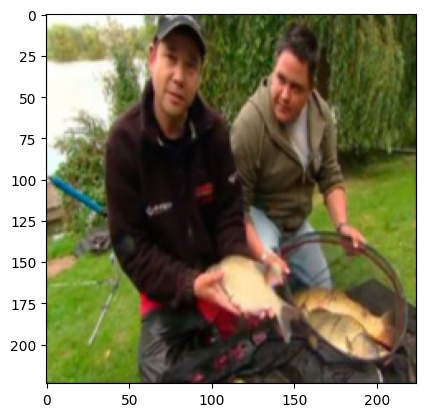

In [ ]:
test_dataset = load_dataset()
test_sample = test_dataset[0]
test_image = test_sample[0]
test_label = test_sample[1]
print(f"This is a photo of a '{labels[test_label]}' which corresponds to class: {test_label}")
show_image(test_image)

### Model: ViT-b 16

[ViT-b/16](https://huggingface.co/google/vit-base-patch16-224) is a Vision Transformer model (ViT), which is a deep learning model  that applies the Transformer architecture to image data. The key idea of ViT is to divide an image into smaller patches, treat each patch as a "token" (similar to words in NLP), and then process these tokens using the Transformer’s attention mechanisms.

<p align="center" text-align="center">
  <img width="60%" src="https://github.com/christiansassi/deep-learning-project/blob/main/assets/img2.png?raw=true">
  <br>
  <span><b>Fig. 2</b> Vision Transformer overview</span>
</p>

**google/vit-base-patch16-224** is a Vision Transformer model with a base configuration, using 16x16 pixel patches and designed for 224x224 pixel input images. It was proposed by researchers at Google in the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929). This model strikes a balance between performance and computational efficiency, making it suitable for various image recognition tasks, such as image classification.

We can load the model in this way:

In [ ]:
from transformers import ViTForImageClassification

# Use cuda if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(model_name: str = "google/vit-base-patch16-224") -> ViTForImageClassification:

    # Load the pre-trained model
    return ViTForImageClassification.from_pretrained(model_name).to(DEVICE)

## Classification

Having defined the dataset and the model that we want to use to classify the images, it is possible to test the capabilities of the model to verify its classification performance. To do this we define some functions useful for the task.

The `classify` function performs image classification using a Vision Transformer (ViT) model. It ensures the image tensor is correctly shaped and moves it to the GPU if available. The model is set to evaluation mode, and inference is conducted with or without gradient calculation. It returns the softmax probabilities of the model's output logits.

In [ ]:
from contextlib import nullcontext

def classify(model: ViTForImageClassification, img: torch.Tensor, no_grad: bool = True) -> dict:

    # Use GPU if available
    if len(img) == 3:
        img = img.unsqueeze(0)
    img = img.to(DEVICE)

    # Perform inference
    model.eval()

    with torch.no_grad() if no_grad else nullcontext():
        outputs = model(img)

    # Extract probabilities from model's output logits
    results = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze()

    return results

The `elaborate_results` function processes the classification probabilities from a model. It loads the model's labels and converts the result tensor into a list if necessary. For each result, it creates a dictionary containing the predicted label and its probability. It iterates through the probabilities, updating the predicted label if a higher probability is found. The function returns the processed results as a dictionary, or a list of dictionaries if there are multiple results.

In [ ]:
def elaborate_results(results: torch.Tensor):

    # Load model's labels
    model_labels = load_model_labels()
    if len(results.shape) == 1:
        results = [results]

    # Process results
    final_results = []
    for result in results:
        item_results = {
            "predicted": {},
            "results": {}
        }
        predicted = None

        for index, probability in enumerate(result):
            item_results["results"][index] = {
                "index": index,
                "label": model_labels[index],
                "probability": probability.item()
            }
            if predicted is None or predicted["probability"] < probability.item():
                predicted = item_results["results"][index]

        item_results["predicted"] = predicted
        final_results.append(item_results)

    return final_results if len(final_results) > 1 else final_results[0]

The `show_predictions` function visualizes the first 9 images from a dataloader along with their true and predicted labels. It uses a pre-trained model (ViT-b/16) to classify each image, then converts the images and displays them in a 3x3 grid.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

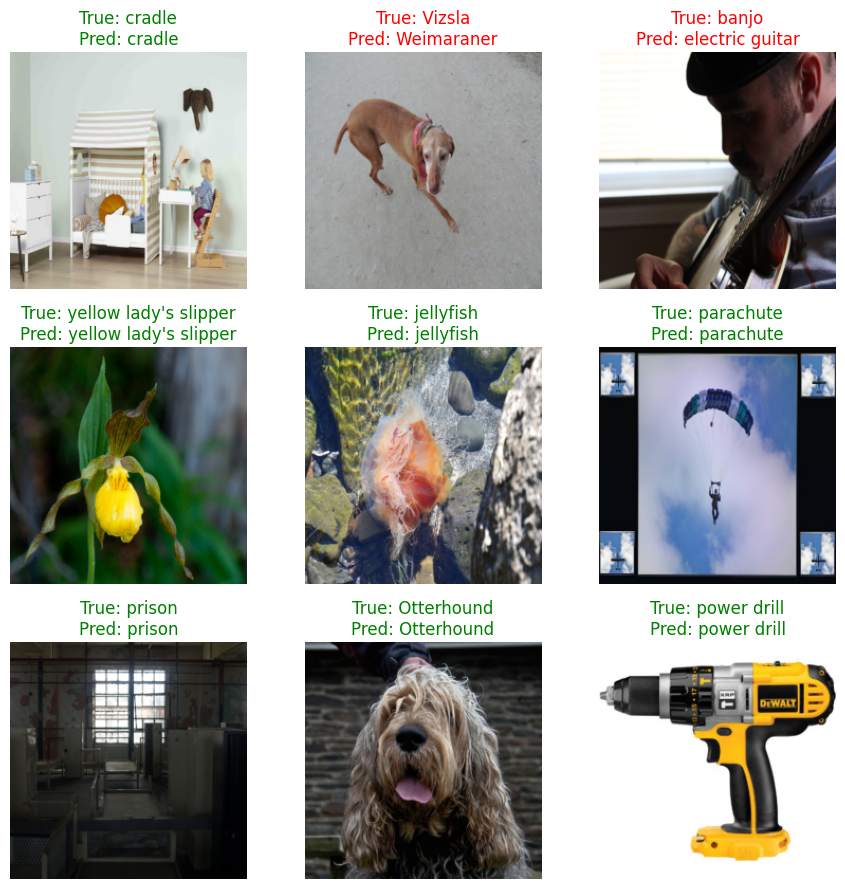

In [ ]:
def show_predictions(dataloader, model, class_names):
    images, labels, predictions = [], [], []

    for i, (img, label) in enumerate(dataloader):
        if i == 9:
            break
        prob = classify(model, img)
        results = elaborate_results(prob)
        pred, result = results["predicted"], results["results"]
        pred = pred["index"]

        images.append(img.squeeze(0))
        labels.append(label.item())
        predictions.append(pred)

    fig, axs = plt.subplots(3, 3, figsize=(9, 9))

    for i, ax in enumerate(axs.flat):
        img = T.ToPILImage()(images[i])
        ax.imshow(img)
        ax.axis('off')
        true_label = class_names[labels[i]]
        pred_label = class_names[predictions[i]]

        if true_label == pred_label:
            color = 'green'
        else:
            color = 'red'

        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)

    plt.tight_layout()
    plt.show()

test_dataloader = load_dataloader()
test_model = load_model()
show_predictions(test_dataloader, test_model, labels)

The `simple_evaluate` function evaluates the accuracy of a trained model on a dataset. It applies resizing and normalization transformations to each image, and iterates through the dataloader. For each image, it predicts its label using the classification function `classify` and compares it with the true label. It accumulates correct predictions to calculate the accuracy. Finally, it prints the overall accuracy after processing all images. <br>
The accuracy obtained evaluating the ViT-b/16 model on ImageNet-v2 is __61.37%__.

In [ ]:
from tqdm import tqdm

normalize_transformation = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def simple_evaluate(model, data_loader):

    accuracy = 0
    transform = T.Resize(SIZE)

    for index, sample in enumerate(tqdm(data_loader, desc="Processing images")):

        image = sample[0]
        label = sample[1]

        # Resize and normalize image
        image = transform(image)
        image = image.to(DEVICE)
        image = normalize_transformation(image)

        # Classify the image
        results = classify(model=model, img=image)
        results = elaborate_results(results=results)
        predicted, results = results["predicted"], results["results"]

        # Update the accuracy
        if label.item() == predicted["index"]:
            accuracy += 1

    print(f"\nFinal accuracy: {(accuracy / (index+1))*100} %")

In [ ]:
simple_evaluate(test_model, test_dataloader)

# MEMO implementation

In the implementation of MEMO, the augmentations used in the creation of the batch take on particular importance.
For the purposes of the project, different types of augmentation were tested, starting from image transformations implemented by hand and also using transformations made available from open source libraries such as *pytorch image models* (timm) and *albumentations*. Only those of *albumentations* will be reported here given their ease of use and completeness in terms of diversity of transformations.

## Augmentations
As will be shown later in the notebook, the augmentations used mainly belong to two separate categories:
- **pixel-level transformations**: they modify the image in a static way, they are in fact operations that modify the color or intensity of individual pixels without modifying their spatial arrangement;
- **spatial-level transformations**: they involve changes to the spatial arrangement of pixels, which can modify the position or orientation of pixels within the image.

The augmentations we use are:
- pixel-level:
    - __equalize__: Adjusts image contrast.
    - __normalize__: Standardizes pixel values.
    - __color_jitter__: Randomly adjusts brightness, contrast, saturation, and hue.
    - __gaussian_blur__: Applies Gaussian blur to the image.
    - __channel_dropout__: Randomly drops channels from the image.
    - __sharpen__: Sharpen the input image and overlays the result with the original image.
- spatial-level:
    - __flip__: Flips the image horizontally or vertically.
    - __elastic__: Applies elastic transformations to distort the image.
    - __grid_distortion__: Distorts the image using a grid pattern.
    - __random_crop__: Crops a random section of the image.
    - __perspective__: Applies perspective transformations to the image.
    - __piecewise_affine__: Distorts the image using piecewise affine transformations.
    - __coarse_dropout__: Randomly drops rectangular regions from the image.
    - __affine__: Applies affine transformations (scaling, rotation, translation).



In [ ]:
!pip install -q -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 28.7 MB/s eta 0:00:00


Each transformation must be initialized with the appropriate arguments, if the default ones are not used, and we set the probability of applying each transformation to 100% (since the original image will be added as the first element of the batch).

In [ ]:
import albumentations as A

# Pixel-level transformations
equalize = A.Equalize(p=1.0)
normalize = A.Normalize(p=1.0)
color_jitter = A.ColorJitter(p=1.0)
gaussian_blur = A.GaussianBlur(p=1.0)
channel_dropout = A.ChannelDropout(p=1.0)
sharpen = A.Sharpen(p=1.0)

# Spatial-level transformations
flip = A.Flip(p=1.0)
elastic = A.ElasticTransform(p=1.0)
grid_distortion = A.GridDistortion(p=1.0)
random_crop = A.Compose([
    A.RandomCrop(width=120, height=120, p=1.0),
    A.Resize(height=224, width=224, p=1.0)
])
perspective = A.Perspective(p=1.0)
piecewise_affine = A.PiecewiseAffine(p=1.0)
coarse_dropout = A.CoarseDropout(
    num_holes_range=(1, 2),
    hole_height_range=(40, 120),
    hole_width_range=(40, 120),
    p=1.0
)
affine = A.Affine(p=1.0)

# Lists of transformations: pixel-level and spatial-level
pixel_transforms = [equalize, normalize, color_jitter, gaussian_blur, channel_dropout, sharpen]
spatial_transforms = [flip, elastic, grid_distortion, random_crop, perspective, piecewise_affine, coarse_dropout, affine]

The `tensor2array` function converts a tensor image to a NumPy array, this is needed since the *albumentations* transformations require an array as input. It scales the tensor values by 255, converts them to 8-bit integers, and rearranges the dimensions from (C, H, W) to (H, W, C). <br>
The `resize_transformation` resizes images to a specified size using *torchvision*'s Resize transform.

In [ ]:
def tensor2array(img):
    img = img * 255
    img = img.to(torch.uint8)

    img_np = img.numpy().transpose(0, 2, 3, 1).squeeze(0)
    return img_np

resize_transformation = T.Resize(SIZE)

The `create_batch` function generates a batch of **n** images, where the first element contains the original image, while the remaining **n-1** elements are images obtained by applying the transformations. Based on the `mode` argument, a different choice is made on the type of transformations applied, in particular:
- `mode = "pixel"` : the **n-1** transformed images are generated via randomly chosen pixel-level transformations
- `mode = "spatial"`: the **n-1** transformed images are generated via randomly chosen spatial-level transformations
- `mode = "combo"`: the **n-1** transformed images are generated through a composition of a randomly chosen spatial-level and pixel-level transformation
- `mode = "<specific_transform>"`: the **n-1** transformed images are generated through one and only one specific transformation chosen by the user.
Once the choice has been made on the type of transformations applied, a tensor of n images (*batch*) is created.

In [ ]:
import random

transforms_dict = {
    "equalize": equalize,
    "normalize": normalize,
    "color_jitter": color_jitter,
    "gaussian_blur": gaussian_blur,
    "channel_dropout": channel_dropout,
    "sharpen": sharpen,

    "flip": flip,
    "elastic": elastic,
    "grid_distortion": grid_distortion,
    "random_crop": random_crop,
    "perspective": perspective,
    "piecewise_affine": piecewise_affine,
    "coarse_dropout": coarse_dropout,
    "affine": affine
}

def create_batch(img, n=8, mode="combo"):
    augmented = []
    img = resize_transformation(img)
    augmented.append(img)
    img = tensor2array(img)

    for _ in range(n-1):
        spatial = random.choice(spatial_transforms)
        pixel = random.choice(pixel_transforms)
        transform = A.Compose([spatial, pixel]) # combo case
        if mode=="spatial":
            transform = spatial
        if mode=="pixel":
            transform = pixel
        if mode in transforms_dict:
            transform = transforms_dict[mode]

        augmented_img = transform(image=img)
        augmented_tensor = T.ToTensor()(augmented_img["image"]).unsqueeze(0)
        augmented.append(resize_transformation(augmented_tensor))
    return torch.cat(augmented, dim=0)

We show a simple example of extracting an image from the dataset and building the batch with the various methods described previously.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


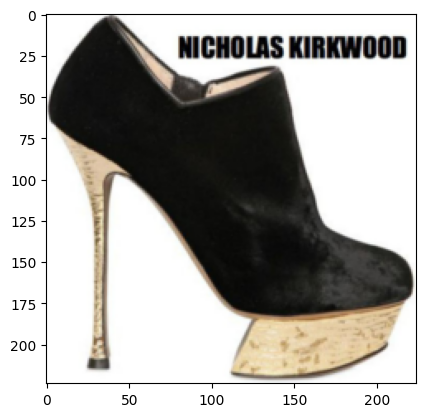

In [ ]:
test_data_loader = load_dataloader()

test_image, test_label = next(iter(test_data_loader))
show_image(test_image)

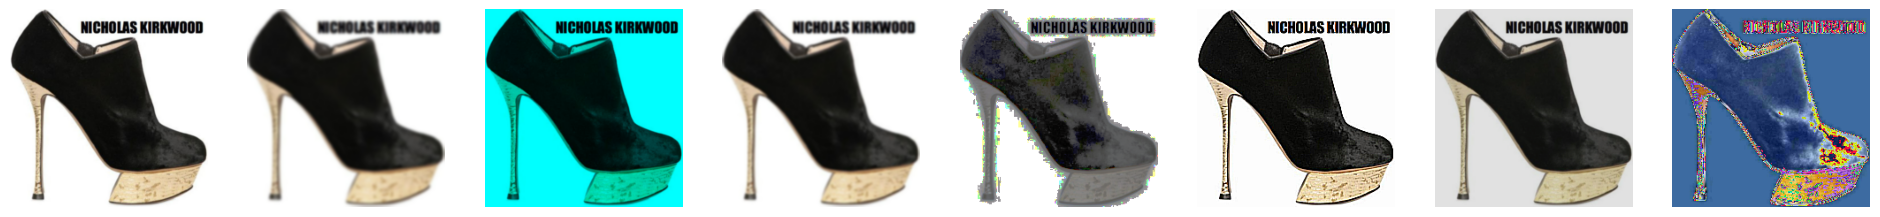

In [ ]:
# Pixel mode
test_batch = create_batch(test_image, mode="pixel")
show_batch_images(test_batch)

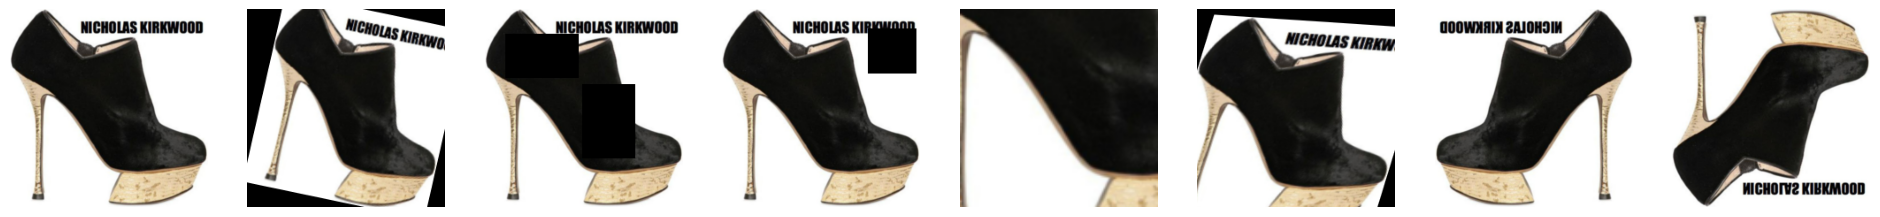

In [ ]:
# Spatial mode
test_batch = create_batch(test_image, mode="spatial")
show_batch_images(test_batch)

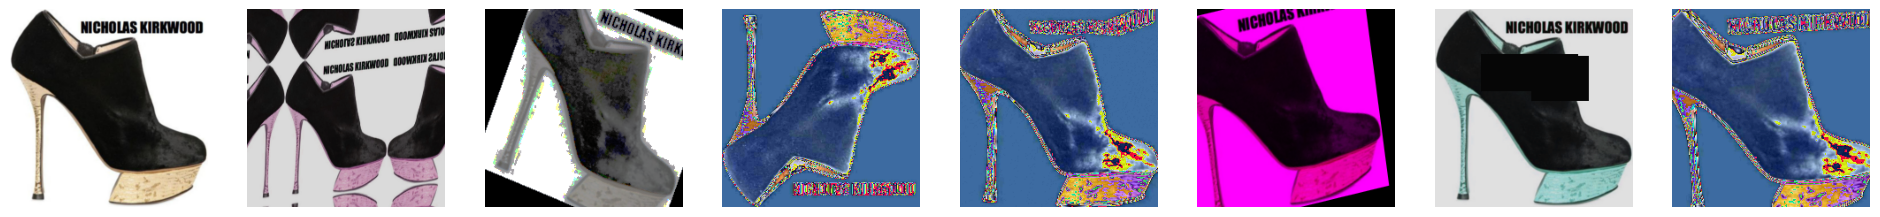

In [ ]:
# Combo mode
test_batch = create_batch(test_image, mode="combo")
show_batch_images(test_batch)

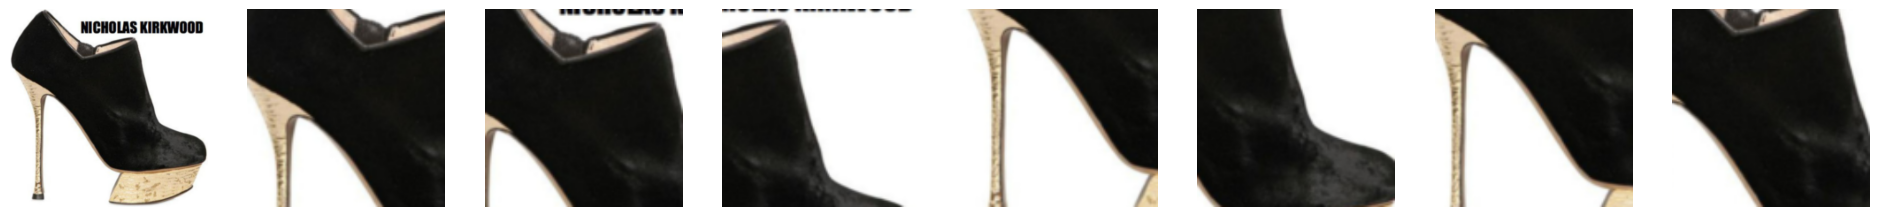

In [ ]:
# Specific transformation mode
test_batch = create_batch(test_image, mode="random_crop")
show_batch_images(test_batch)

## Optimization


This approach leverages data augmentation to expose the model to a more diverse set of training examples, thereby improving its robustness and accuracy. The entropy-based loss ensures that the model's predictions become more certain and consistent, enhancing its performance on unseen data.

Here we go through a detailed description of the evaluation and optimization process:
- **Initial Setup**: The function initializes accuracy counters and loads the pre-trained model **ViT-b/16**. It also prepares the dataloader for the dataset and copies the initial model state to reset later.

- **Data Processing**: For each sample in the dataloader, the function resizes and normalizes the original image. It then creates a batch of augmented images using the _create_batch function specified. This batch includes the original image and several augmented versions.

- **Original Model Classification**: The model classifies the original, unaugmented image to establish a baseline accuracy. The predicted label is compared to the true label, updating accuracy_before if correct.

- **Optimization Process**:

    - **Model Reset**: The model is reset to its initial state before optimization.
    - **Optimizer Setup**: An AdamW optimizer is initialized to update the model parameters during training.
    - **Gradient Calculation**: The model processes the batch of augmented images, and the softmax probabilities of the output logits are computed.
    - **Entropy Calculation**: The marginal probability distribution is calculated as the mean of the batch probabilities. The entropy of this distribution is computed and used as the loss function. Entropy is a measure of uncertainty, and minimizing it helps in making the model's predictions more confident and reliable.
    - **Backpropagation**: The entropy loss is backpropagated to calculate gradients, and the optimizer updates the model parameters.
    - **Post-Optimization Classification**: The model classifies the original image again after optimization. The predicted label is compared to the true label, updating accuracy_after if correct.

- **Accuracy Calculation and Logging**: After processing all samples, the function calculates the final accuracy before and after optimization. It logs these results, including the differences, to a specified output file.


In [ ]:
from datetime import datetime
from copy import deepcopy
import torch.optim as optim


def evaluate(n=8, lr=5e-5, _create_batch=create_batch, mode="combo", to_stop=None, filename="outputs.txt"):

    accuracy = 0

    # Load model (only once)
    model = load_model()
    original_model = deepcopy(model)

    data_loader = load_dataloader()

    # Save the initial state of the model
    initial_state = model.state_dict().copy()

    for index, sample in enumerate(tqdm(data_loader, desc="Processing images")):

        if to_stop is not None:
            if index+1 >= to_stop:
                break

        original_image = sample[0]
        label = sample[1]

        # Reset the initial state of the model
        model = deepcopy(original_model)
        model.eval()

        optimizer = optim.AdamW(model.parameters(), lr=lr)
        # Set the gradients to zero before calculating the new ones
        optimizer.zero_grad()

        # Resize and normalize the image
        image = resize_transformation(original_image)
        image = image.to(DEVICE)
        image = normalize_transformation(image)

        batch = _create_batch(original_image, n, mode)
        batch = normalize_transformation(batch)


        # Calculate the model outputs on the batch
        output = model(batch.to(DEVICE))

        # Combine the output probabilities
        probabilities = torch.nn.functional.softmax(output.logits, dim=-1).squeeze().to(DEVICE)

        # Calculate the entropy
        marginal = torch.mean(probabilities, dim=0).to(DEVICE)
        entropy = -torch.sum(marginal * torch.log(marginal)).to(DEVICE)
        entropy.backward()

        # Gradient step
        optimizer.step()

        # Classify the image after the optimization step
        results = classify(model=model, img=image)
        results = elaborate_results(results=results)
        predicted, results = results["predicted"], results["results"]

        # Update the accuracy
        if label.item() == predicted["index"]:
            accuracy += 1

    print(f"\nFinal accuracy after optimization: {round((accuracy / (index+1))*100, 2)} % (before optimization was 61.37 %)")

    label1 = f"Image {index + 1} / {len(data_loader)}"
    label2 = f"Accuracy before: 61.37 %"
    label3 = f"Accuracy after: {round((accuracy / (index+1)) * 100, 1)} % ({accuracy} / {index+1})"
    label4 = f"Diff: {round((accuracy / (index+1)) * 100, 2) - 61.37} %"

    current_time = datetime.now().strftime("%H:%M:%S")
    string = f"{current_time}: with {_create_batch.__name__}, lr {lr}, {n} augs, mode {mode}\n" + f"{label1} | {label2} | {label3} | {label4}\n"

    with open(filename, 'a') as file:
        file.write(string)
        file.write("\n")

In [ ]:
evaluate(n=8, lr=5e-5, _create_batch=create_batch, mode="spatial", to_stop=None, filename="outputs.txt")

## Results discussion

Through the evaluation script it is possible to launch many experiments with different setups (in terms of learning rate, number of elements in the batch, type of transformations applied). In this analysis of the results we mainly focus on the type of transformations used and the orientation to their choice.

All the data collected is compared with the accuracy of the previously calculated baseline, which turns out to be **61.37%**.

As a first experiment we decided to evaluate the global effectiveness of **each specific transformation**, calculating the gain (or loss) in classification performance. The results obtained can be summarized in this table:

|      AUGMENTATION      |    GAIN    |
|:-------------:|:----------:|
|PIXEL-LEVEL|
| equalize |  -3.91 %   |
| normalize |  +0.16 %   |
| color_jitter |  +0.29 %   |
| gaussian_blur |  -2.31 %   |
| channel_dropout |  -2.93 %   |
| sharpen |  -5.55 %   |
|SPATIAL-LEVEL|
|      flip     |  -1.70 %   |
|    elastic    |  +0.01 %   |
| grid_distortion |  +0.98 %   |
|  random_crop  |  +3.08 %   |
| perspective   |  +2.48 %   |
|    affine     |  +0.72 %   |
| piecewise_affine |  +0.61 %   |
| coarse_dropout |  -1.64 %   |

This results can be obtained by launching this script:
``` python
for aug in transforms_dict:
    evaluate(n=8, lr=5e-5, _create_batch=create_batch, mode=aug, to_stop=None, filename="outputs.txt")
```

As can be seen from the results obtained, the pixel-level transformations are not at all effective for optimization purposes, given that for each of the transformations there are significant performance losses (or at most a negligible gain).
On the contrary, spatial-level transformations offer important gains in terms of accuracy, in particular the `random_crop` transformation seems to perform much better, with a gain of **+3.08%**.

For the reasons mentioned, our analysis focused on spatial-level transformations.

A feasible approach is to build the batch of images by choosing, for every *n-1* images in the batch, a random transformation among the spatial ones. In this way, counting the number of occurrences of each transformation in the creation of the batch, each augmentation will appear approximately 12.5% ​​(1/8 given that there are 8 possible spatial transformations to choose from) of the time, once the complete evaluation. It could therefore be expected that with an approach of this type it is possible to obtain a total gain on classification performance corresponding to the average of the gains for the individual transformations, i.e. approximately **+0.57%**. However, by running the actual evaluation with this method of choosing transformations we obtain a total gain of **+1.33%**, suggesting that the variety of transformations helps the model to generalize better, making it more robust to different variations of the images.

|        AUGMENTATION        | OCCURENCES |     PERCENTAGE      |
|:-----------------:|:-------:|:----------:|
|       flip        |  8732   |  12.47%    |
|      elastic      |  8680   |  12.40%    |
| grid_distortion   |  8763   |  12.52%    |
|   random_crop     |  8849   |  12.64%    |
|   perspective     |  8823   |  12.60%    |
|      affine       |  8698   |  12.43%    |
| piecewise_affine  |  8779   |  12.54%    |
|  coarse_dropout   |  8676   |  12.39%    |


It is therefore possible to think of finding a more effective choice method than the simple homogeneous random choice of the transformations. The idea is therefore to attribute a greater probability of choice to those transformations that individually guarantee superior performance and instead a lower probability of choice to the others. In particular, those transformations that offer zero or negative gain are not considered, while the choice will fall with varying probabilities on those that offer positive gains. A choice criterion with these characteristics can be obtained through the use of **softmax**, a function that takes logits as input and returns a probability distribution as output (positive values ​​with a sum of 1).
These probabilities can be seen in this table:

|      AUGMENTATION      |    GAIN    | PROBABILITY|
|:-------------:|:----------:|:---------:|
|      flip     |  -1.70 %   | - |
|    elastic    |  +0.01 %   | - |
| grid_distortion |  +0.98 %   | 7 %|
|  random_crop  |  +3.08 %   | 54 %|
| perspective   |  +2.48 %   | 30 %|
|    affine     |  +0.72 %   | 5 %|
| piecewise_affine |  +0.61 %   | 4 %|
| coarse_dropout |  -1.64 %   | - |

With this approach, very satisfactory results were obtained, corresponding to an absolute gain in classification performance of **+2.98 %**.

In [ ]:
def create_batch_prob(img, n=8, mode=None):
    # Transformation index
    values = [0, 1, 2, 3, 4, 5, 6, 7]
    # Probability for every transformation
    probabilities = [0.0, 0.0, 0.07, 0.54, 0.30, 0.05, 0.04, 0.0]

    augmented = []
    img = resize_transformation(img)
    augmented.append(img)
    img = tensor2array(img)

    aug_indexes=[]
    for i in range(n-1):
        index = random.choices(values, probabilities)[0]
        aug_indexes.append(index)

    for i in aug_indexes:
        transform = spatial_transforms[i]
        augmented_img = transform(image=img)
        augmented_tensor = T.ToTensor()(augmented_img["image"]).unsqueeze(0)
        augmented.append(resize_transformation(augmented_tensor))
    return torch.cat(augmented, dim=0)

In [ ]:
# Create batch with different probabilities for every transformation
test_batch = create_batch_prob(test_image)
show_batch_images(test_batch)

In [ ]:
evaluate(n=8, lr=5e-5, _create_batch=create_batch_prob, to_stop=None, filename="outputs_prob.txt")

# Authors
This project was developed by:
- Matteo Beltrami [248333]
- Pietro Bologna [248715]
- Christian Sassi [248724]